# Finite Time Lyapunov Exponent (FTLE) analysis
### Author: Justine John (JJ) A. Serdoncillo 
### Date Created: August 1, 2023
---
#### Updates due to previous concerns
- [x] fixing initialization of particles
    - no more overlapping with airfoil
- fixing particle boundary crossing
    - [ ] 0 velocity
    - [ ] delete
    - [ ] pertube to outside
        - teleport
        - mirror bounce
- fixing particle trajectory outside of bounds
    - convect same as freestream
    - velocity on edge of rectangle
---

# <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Karthik Functions](#1)
2. [Read Data](#2)
3. [Particle Tracking](#3)
4. [FTLE Calculation](#4)
5. [Visualization](#5)
6. [Save Data](#6)

## Simulation data for two-dimensional flow around a pitching NACA0015 airfoil at $Re = 1000$

### Airfoil kinematics: $\theta = \theta_0 + \Delta \theta sin(2\pi f^*t)$, where $f^* = 0.15$, $\Delta \theta = 25^{\circ}$, $\theta_0 = 15^{\circ}$.
***
***

## <font color='289C4E'>Karthik Functions<font><a id='1'></a>


In [1]:
using FileIO, ImageMagick, Colors, FixedPointNumbers, DelimitedFiles, PyPlot, LinearAlgebra, HDF5

<div class="alert alert-block alert-warning">  
<b> If error:</b> Run the code below 
</div>

### Function: Read the coordinates of the Cartesian grid from the simulation data
The grid used for the simulation is stored in `xgrid.dat` and `ygrid.dat` files for X and Y directions

In [2]:
function set_grid()
    global overall_path
    # Read grid files
    gridfile = overall_path * "xgrid.dat"
    x_grid = readdlm(gridfile)[:,2]
    gridfile = overall_path * "ygrid.dat"
    y_grid = readdlm(gridfile)[:,2]
    # Create arrays for cell-centered grid points
    nxc = size(x_grid, 1) - 1
    nyc = size(y_grid, 1) - 1
    xc = zeros(nxc)
    yc = zeros(nyc)
    # Convert face-centered to cell-centered coordinates
    for i in 1:nxc
        xc[i] = 0.5 * (x_grid[i] + x_grid[i+1])
    end
    for j in 1:nyc
        yc[j] = 0.5 * (y_grid[j] + y_grid[j+1])
    end
    return nxc, nyc, xc, yc
end;

### Function: Read data within a rectangular subdomain inside the cartesian grid.

>#### Function arguments:
`data_path`: Location of simulation data files (`qout*.dat` data files)<br>
`tstep`: Timestep to read<br>
`varlist`: Indices of variables to read (depends on the format of the data file being read)<br>
`nxc`, `nyc`: Number of grid points in the X and Y directions (cell-centered)<br>
`xstart`, `xend`, `ystart`, `yend`: Start and end indices of the "box" to be read within the grid in the X and Y direction

In [3]:
function read_subdomain_data(data_path,tstep,varlist,nxc,nyc,xstart,xend,ystart,yend)
    filename = data_path * "qout." * lpad(Int(tstep),7,'0') * ".dat"
    f = open(filename,"r")
    # Vector to store all the variables read in a flattened representation
    result = []
    # Iterate through list of variables to read
    for varnum in varlist
        # Move to the start of each variable in the binary file
        seek(f,8*nxc*nyc*(varnum-1))
        # Read nxc*nyc entries corresponding to the current variable on the grid
        fullfield = reinterpret(Float64, read(f, 8*nxc*nyc))
        # Reshape the flattened array read above to a 2D matrix
        fullfield_2d = reshape(fullfield,(nxc,nyc))
        # Store the part of the grid contained within the box [xstart,xend],[ystart,yend]
        field_subdomain = fullfield_2d[xstart:xend-1,ystart:yend-1]
        # Flatten and store the variable within the "box"/subdomain of the grid
        result = vcat(result,vec(field_subdomain))
    end
    close(f)
    return result
end;

## <font color='289C4E'>Read Data<font><a id='2'></a>
### Reading all the data at once 

#### Set up the Cartesian grid

In [4]:
# Select computer 
hp = "/Users/jjser/Desktop/Julia_FTLE_Karthik_Data/airfoil2D_f0.15_amp25deg_KM/"
vr = "/Users/GreenFluids_VR/Desktop/airfoil2D_f0.15_amp25deg_KM/"
overall_path = vr

nxc,nyc,xc,yc = set_grid();

#### Specify the timesteps that need to be read, and the size of the subdomain to read

In [5]:
# Timesteps to read from qout.*.dat files
tstep_start =  200
tstep_end = 150000
og_tstep_delta = 200

og_num_tsteps = Int64((tstep_end-tstep_start)/og_tstep_delta + 1)

og_tstep_range = collect(range(tstep_start, tstep_end, length=og_num_tsteps))

# Spatial extent of a rectangular "box"/subdomain within the Cartesian grid to read
x_start_loc = 1.0
x_end_loc = 16.0
y_start_loc = 1.0
y_end_loc = 18.0

# Find indices in the grid corresponding to above X and Y coordinates
x_start = argmin(abs.(xc.-x_start_loc))
x_end = argmin(abs.(xc.-x_end_loc))+1
y_start = argmin(abs.(yc.-y_start_loc))
y_end = argmin(abs.(yc.-y_end_loc))+1

# Number of grid points in the "box"/subdomain within the Cartesian grid to read
nx_subdomain = x_end-x_start
ny_subdomain = y_end-y_start
subdomain_size = nx_subdomain*ny_subdomain;

#### Read the variables needed

In [6]:
x_range = xc[x_start:x_end]
y_range = yc[y_start:y_end]

var_list = [1,2,4,5];
var_names = ["u","v","iblank","vorticity"];
# Number of variables
numvar = length(var_list)

# Dictionary associating the order of variable names with indices
var_idxs = Dict(zip(var_names,1:numvar))

# Data object to store all variables at all timesteps
# For each timestep, all variables are stored sequentially as flattened arrays
data = zeros(nx_subdomain*ny_subdomain*numvar,og_num_tsteps)

for (i,tstep) in enumerate(og_tstep_range)
    data_subdomain = read_subdomain_data(overall_path,tstep,var_list,nxc,nyc,x_start,x_end,y_start,y_end)
    data[:,i] = data_subdomain[:]
end
println("DONE")

In [7]:
println(size(x_range))
println(size(y_range))

(367,)
(320,)


#### Choose number of intermediate snapshots and then store into arrays

In [8]:
inter = 4
num_tsteps = (og_num_tsteps-1)*inter+1
tstep_delta = og_tstep_delta/inter
Vel_contour = zeros(Float64, 2, num_tsteps, ny_subdomain, nx_subdomain)
Bvo_contour = zeros(Float64, 2, num_tsteps, ny_subdomain, nx_subdomain)

for i in 1:og_num_tsteps-1
    u1 = data[1:subdomain_size,i]
    u2 = data[1:subdomain_size,i+1]
    v1 = data[subdomain_size+1:2*subdomain_size,i]
    v2 = data[subdomain_size+1:2*subdomain_size,i+1]
    b1 = data[2*subdomain_size+1:3*subdomain_size,i]
    b2 = data[2*subdomain_size+1:3*subdomain_size,i+1]
    o1 = data[3*subdomain_size+1:4*subdomain_size,i]
    o2 = data[3*subdomain_size+1:4*subdomain_size,i+1]
    
    for p in 0:inter-1
        uu = u1*(inter-p)/inter + u2*(p)/inter
        vv = v1*(inter-p)/inter + v2*(p)/inter
        bb = b1*(inter-p)/inter + b2*(p)/inter
        oo = o1*(inter-p)/inter + o2*(p)/inter
        Vel_contour[1, inter*(i-1)+p+1, :, :] =  transpose(reshape(uu,(length(x_range)-1,length(y_range)-1)))
        Vel_contour[2, inter*(i-1)+p+1, :, :] =  transpose(reshape(vv,(length(x_range)-1,length(y_range)-1)))
        Bvo_contour[1, inter*(i-1)+p+1, :, :] = (transpose(reshape(bb,(length(x_range)-1,length(y_range)-1))) .> 0.5) .|> Int
        Bvo_contour[2, inter*(i-1)+p+1, :, :] =  transpose(reshape(oo,(length(x_range)-1,length(y_range)-1)))
    end
    
    if i == og_num_tsteps-1
        Vel_contour[1, num_tsteps, :, :] =  transpose(reshape(u2,(length(x_range)-1,length(y_range)-1)))
        Vel_contour[2, num_tsteps, :, :] =  transpose(reshape(v2,(length(x_range)-1,length(y_range)-1)))
        Bvo_contour[1, num_tsteps, :, :] = (transpose(reshape(b2,(length(x_range)-1,length(y_range)-1))) .> 0.5) .|> Int
        Bvo_contour[2, num_tsteps, :, :] =  transpose(reshape(o2,(length(x_range)-1,length(y_range)-1)))
    end
end
println("DONE")

## <font color='289C4E'>Particle Tracking and FTLE calculation<font><a id='3'></a>

### Function: Find index of position

>#### Function arguments:
`x`: X-position <br>
`y`: Y-position

In [9]:
function find_me(xval, yval)
    x1 = argmin(abs.(x_range .- xval))
    y1 = argmin(abs.(y_range .- yval))

    if x1 >= size(x_range)[1]-1
        x1 -= 3
    end
    
    if y1 >= size(y_range)[1]-1
        y1 -= 3
    end

    x2 = x1 + 1
    y2 = y1 + 1
    
    return x1, x2, y1, y2
end

find_me (generic function with 1 method)

### Function: Check if cross boundary

>#### Function arguments:


In [71]:
function isCross(xx, yy, t)
    xind = argmin(abs.(y_range.-yy))
    yind = argmin(abs.(x_range.-xx))
    return Bvo_contour[1, t, xind, yind] == 1
end

isCross (generic function with 1 method)

### Function: Magic push or pertubed

>#### Function arguments:


In [ ]:
function magic(p, v, option)
    if option=="noVel"
        p = p
    elseif option=="gone"
        p .= NaN
    elseif opttion=="bounce
        p = p .+ 0.1
    return p
end
    

### Function: Calculate particle trajectories and FTLE field

>#### Function arguments:
`nx`, `ny`: Number of particles in the X and Y directions  
`x0`, `x1`, `y0`, `y1`: X and Y domain of the instantiated particles
`t_0`, `t_1`: Start and end time of the flow

In [ ]:
for ii in 1:nx, jj in 1:ny
    particles[1,:,ii, :] .= x[ii]
    particles[2,:, :,jj] .= y[jj]
end

for ii in 1:nx, jj in 1:ny
    xind = argmin(abs.(y_range.-particles[2,1,ii,jj]))
    yind = argmin(abs.(x_range.-particles[1,1,ii,jj]))
    if Bvo_contour[1,1,xind,yind] == 1
        particles[:,1,ii,jj] .= NaN
    end
end

for ii in 1:nx, jj in 1:ny
    xind = argmin(abs.(y_range.-y[jj])
    yind = argmin(abs.(x_range.-x[ii])
    if Bvo_contour[1,1,xind,yind] == 1
        particles[:,1,ii,jj] .= NaN
    else
        particles[:,1,ii,jj] .= [x[ii], y[jj]] 
    end
end



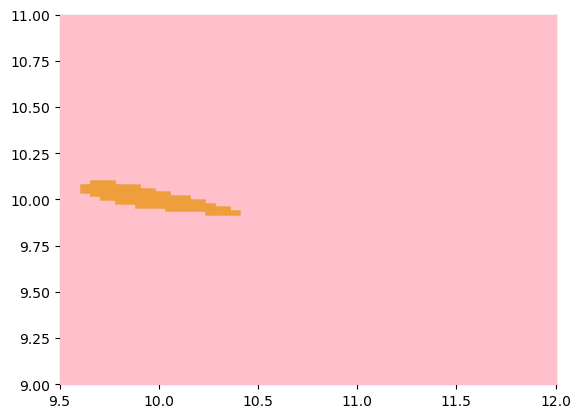

(9.0, 11.0)

In [73]:
nx,ny,x0,x1,y0,y1,t_0,t_1 = 100,100,9.5,12.0,9.0,11.0,68800,69800
move = sign(t_1-t_0)
tstep_range = collect(range(tstep_start, tstep_end, length=num_tsteps))
t_0_ind = argmin(abs.(tstep_range .- t_0))
t_1_ind = argmin(abs.(tstep_range .- t_1))
tsteps = Int64(abs(t_1 - t_0)/tstep_delta + 1)
x = collect(range(x0, x1, length=nx))
y = collect(range(y0, y1, length=ny))
particles = zeros(3, tsteps+1, nx, ny)

for ii in 1:nx, jj in 1:ny
    particles[1,1,ii, :] .= x[ii]
    particles[2,1, :,jj] .= y[jj]
end

for ii in 1:nx, jj in 1:ny
    if isCross(x[ii],y[jj],1) == 1
        particles[:,1,ii,jj] .= NaN
    end
end

fig, ax = subplots()
ax.scatter(particles[1,1,:,:],particles[2,1,:,:],marker="s",color="pink",zorder=3)
ax.contourf(x_range[1:end-1],y_range[1:end-1],Bvo_contour[1,1,:,:], levels=levels,cmap=ColorMap("PuOr"), zorder=1)
ax.set_xlim([9.5,12])
ax.set_ylim([  9,11])


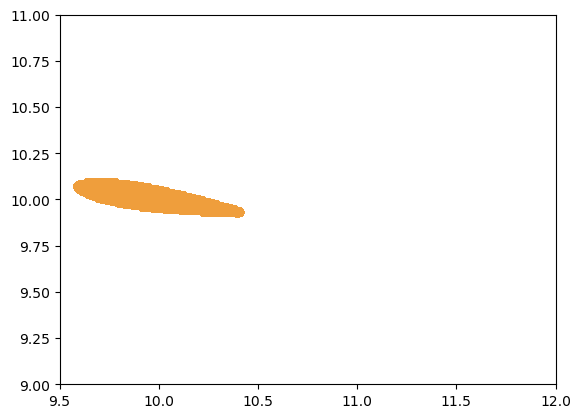

(9.0, 11.0)

In [15]:
fig, ax = subplots()
levels = range(0, 1,length=3) .+ 0.5
ax.contourf(x_range[1:end-1],y_range[1:end-1],Bvo_contour[1,1,:,:], levels=levels,cmap=ColorMap("PuOr"), zorder=1)
ax.set_xlim([9.5,12])
ax.set_ylim([  9,11])

In [48]:
function FTLE(nx,ny,x0,x1,y0,y1,t_0,t_1)
    move = sign(t_1-t_0)
    tstep_range = collect(range(tstep_start, tstep_end, length=num_tsteps))
    t_0_ind = argmin(abs.(tstep_range .- t_0))
    t_1_ind = argmin(abs.(tstep_range .- t_1))
    tsteps = Int64(abs(t_1 - t_0)/tstep_delta + 1)
    x = collect(range(x0, x1, length=nx))
    y = collect(range(y0, y1, length=ny))
    particles = zeros(3, tsteps+1, nx, ny)

    for ii in 1:nx, jj in 1:ny
        particles[1,1,ii, :] .= x[ii]
        particles[2,1, :,jj] .= y[jj]
    end

    for ii in 1:nx, jj in 1:ny
        xind = argmin(abs.(y_range.-particles[2,1,ii,jj]))
        yind = argmin(abs.(x_range.-particles[1,1,ii,jj]))
        if Bvo_contour[1,1,xind,yind] == 1
            particles[:,1,ii,jj] .= NaN
        end
    end
    
    x = copy(x_range)
    y = copy(y_range)
    # Iterate through all timesteps 
    count = 1
    for tt in t_0_ind:move:t_1_ind
        for ii in 1:nx, jj in 1:ny
            if any(isnan,particles[1:2,count,ii,jj]) == false 
                # Let's use Runge Kutta 4th order
                kxy = zeros(4,2)
                a = particles[1,move*(tt-t_0_ind)+1,ii,jj]
                b = particles[2,move*(tt-t_0_ind)+1,ii,jj]
                #=Runge Kutta 4th Order K1 =#
                c = copy(a)
                d = copy(b)
                x1, x2, y1, y2 = find_me(c, d)
                for UV in 1:2
                    kxy[1,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                                   (x[x2]-c)*(y[y2]-d)*Vel_contour[UV,tt,y1,x1] + 
                                   (c-x[x1])*(y[y2]-d)*Vel_contour[UV,tt,y2,x1] +
                                   (x[x2]-c)*(d-y[y1])*Vel_contour[UV,tt,y1,x2] +
                                   (c-x[x1])*(d-y[y1])*Vel_contour[UV,tt,y2,x2] )
                end
                #=Runge Kutta 4th Order K2 =#
                c = a + 0.5*kxy[1,1]*tstep_delta/1000
                d = b + 0.5*kxy[1,2]*tstep_delta/1000
                x1, x2, y1, y2 = find_me(c, d)
                for UV in 1:2
                    kxy[2,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                                   (x[x2]-c)*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y1,x1]+Vel_contour[UV,tt+move,y1,x1]) + 
                                   (c-x[x1])*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y2,x1]+Vel_contour[UV,tt+move,y2,x1]) +
                                   (x[x2]-c)*(d-y[y1])*0.5*(Vel_contour[UV,tt,y1,x2]+Vel_contour[UV,tt+move,y1,x2]) +
                                   (c-x[x1])*(d-y[y1])*0.5*(Vel_contour[UV,tt,y2,x2]+Vel_contour[UV,tt+move,y2,x2]) )
                end
                #=Runge Kutta 4th Order K3 =#
                c = a + 0.5*kxy[2,1]*tstep_delta/1000
                d = b + 0.5*kxy[2,2]*tstep_delta/1000
                x1, x2, y1, y2 = find_me(c, d)
                for UV in 1:2
                    kxy[3,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                                   (x[x2]-c)*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y1,x1]+Vel_contour[UV,tt+move,y1,x1]) + 
                                   (c-x[x1])*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y2,x1]+Vel_contour[UV,tt+move,y2,x1]) +
                                   (x[x2]-c)*(d-y[y1])*0.5*(Vel_contour[UV,tt,y1,x2]+Vel_contour[UV,tt+move,y1,x2]) +
                                   (c-x[x1])*(d-y[y1])*0.5*(Vel_contour[UV,tt,y2,x2]+Vel_contour[UV,tt+move,y2,x2]) )
                end
                #=Runge Kutta 4th Order K4 =#
                c = a + kxy[3,1]*tstep_delta/1000
                d = b + kxy[3,2]*tstep_delta/1000
                x1, x2, y1, y2 = find_me(c, d)
                for UV in 1:2
                    kxy[4,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                                   (x[x2]-c)*(y[y2]-d)*Vel_contour[UV,tt+move,y1,x1] + 
                                   (c-x[x1])*(y[y2]-d)*Vel_contour[UV,tt+move,y2,x1] +
                                   (x[x2]-c)*(d-y[y1])*Vel_contour[UV,tt+move,y1,x2] +
                                   (c-x[x1])*(d-y[y1])*Vel_contour[UV,tt+move,y2,x2] )
                end
                for UV in 1:2
                    particles[UV,move*(tt-t_0_ind)+2,ii,jj] = particles[UV,move*(tt-t_0_ind)+1,ii,jj] + sign(move)*(kxy[1,UV]+2*kxy[2,UV]+2*kxy[3,UV]+kxy[4,UV])*tstep_delta/6000
                end
            end
        end
        count += 1
    end
    
#=
    for tt in 1:tsteps
        for ii in 2:nx-1
            for jj in 2:ny-1
                ul = (particles[1,tt,ii+1,jj]-particles[1,tt,ii-1,jj])/(particles[1,1,ii+1,jj]-particles[1,1,ii-1,jj])
                ur = (particles[2,tt,ii+1,jj]-particles[2,tt,ii-1,jj])/(particles[2,1,ii,jj+1]-particles[2,1,ii,jj-1])
                ll = (particles[1,tt,ii,jj+1]-particles[1,tt,ii,jj-1])/(particles[1,1,ii+1,jj]-particles[1,1,ii-1,jj])
                lr = (particles[2,tt,ii,jj+1]-particles[2,tt,ii,jj-1])/(particles[2,1,ii,jj+1]-particles[2,1,ii,jj-1])
                B = [ul ur; ll lr]
                A = transpose(B) * B
                G = eigvals(A)
                H = ones(length(G))
                for i in 1:length(H)
                    H[i] = abs(G[i])
                end
                sigma = maximum(H)
                particles[3,tt+1,ii,jj] = 0.5/tstep_delta*log(sigma)
            end
        end
    end
=#
    
    flow = particles[:,:,2:nx-1,2:ny-1]
    println("done")

    return flow
end

FTLE (generic function with 1 method)

<div class="alert alert-block alert-success">  
<b> Example:</b> FTLE for forward and then backward along one cycle
</div>

In [54]:
p50 = FTLE(50,50,9.5,12.0,9.0,11.0,66800,69800)
#n50 = FTLE(5,5,9.5,12.0,9.0,11.0,72800,69800)
print("DONE")

done
DONE

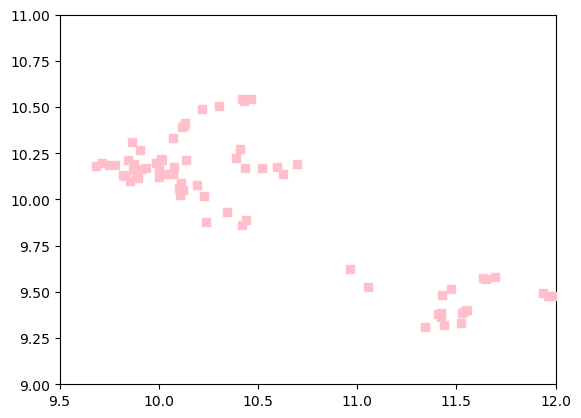

(9.0, 11.0)

In [60]:
fig, ax = subplots()
ts = 61
ax.scatter(p50[1,ts,:,:],p50[2,ts,:,:],marker="s",color="pink",zorder=3)
ax.set_xlim([9.5,12])
ax.set_ylim([  9,11])

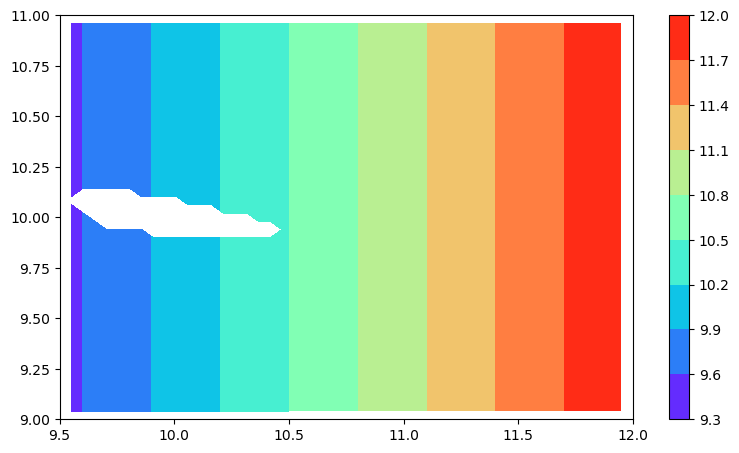

PyObject <matplotlib.colorbar.Colorbar object at 0x000001FB9E596A40>

In [67]:
tstep = 1
x = p50[1,1,:,:]
y = p50[2,1,:,:]
z = p50[1,tstep,:,:]
fig, ax = subplots(figsize=(9.25,5.25))
cm = ax.contourf(x,y,z,cmap=ColorMap("rainbow"))
ax.set_xlim([9.5,12])
ax.set_ylim([  9,11])
fig.colorbar(cm)

## <font color='289C4E'>FTLE Calculation<font><a id='4'></a>

### Function: Filter values over certain% of the maximum FTLE 

>#### Function arguments:
`field`: particle flow field and FTLE values  
`limFTLE`: Filter value for visualizing ridges

In [61]:
function filterFTLE(field, limFTLE)
    manifolds = (field[3,:,:,:] .> limFTLE * maximum(field[3,:,:,:])) .|> Int
    return manifolds
end

filterFTLE (generic function with 1 method)

<div class="alert alert-block alert-success">  
<b> Example:</b> Calculate FTLE
</div>

In [64]:
limFTLE = 0.67
pFTLE = filterFTLE(p50, 0.67)
nFTLE = filterFTLE(n50, 0.67)
print("DONE")

LoadError: UndefVarError: `n50` not defined

## <font color='289C4E'>Visualization<font><a id='5'></a>

### Function: Plot flow map based on the original x position

>#### Function arguments:
`field`: particle flow field and FTLE values    
`tstep`: time step wanted  
`levels`: levels for the colorbar

In [62]:
function xflowMap(field, tstep, levels)
    x = field[1,1,:,:]
    y = field[2,1,:,:]
    z = field[1,tstep,:,:]
    fig, ax = subplots(figsize=(9.25,5.25))
    cm = ax.contourf(x,y,z,cmap=ColorMap("rainbow"),levels=levels)
    fig.colorbar(cm)
    title("Flow Map at "*string((tstep-1)*tstep_delta+tstep_start) *"ms")
end

xflowMap (generic function with 1 method)

### Function: Plot unstable and stable manifolds based on FTLE

>#### Function arguments:
`pos`: positive FTLE field  
`neg`: negative FTLE field  
`tstep`: time step wanted  

In [ ]:
function ftle(pos, neg, tstep)
    x = pos[1,1,:,:]
    y = pos[2,1,:,:]
    p = filterFTLE(pos, 0.67)
    n = filterFTLE(neg, 0.67)
    fig, ax = subplots(figsize=(9.25,5.25))
    levels = range(0, 1,length=3) .+ 0.5
    ax.contourf(x[:,:],y[:,:],p[tstep,:,:],cmap=ColorMap("Blues"),levels=levels, alpha=0.5, zorder=1)
    ax.contourf(x[:,:],y[:,:],n[tstep,:,:],cmap=ColorMap("Reds") ,levels=levels, alpha=0.5, zorder=2)
end

<div class="alert alert-block alert-success">  
<b> Example:</b> Flow map and FTLE fields
</div>

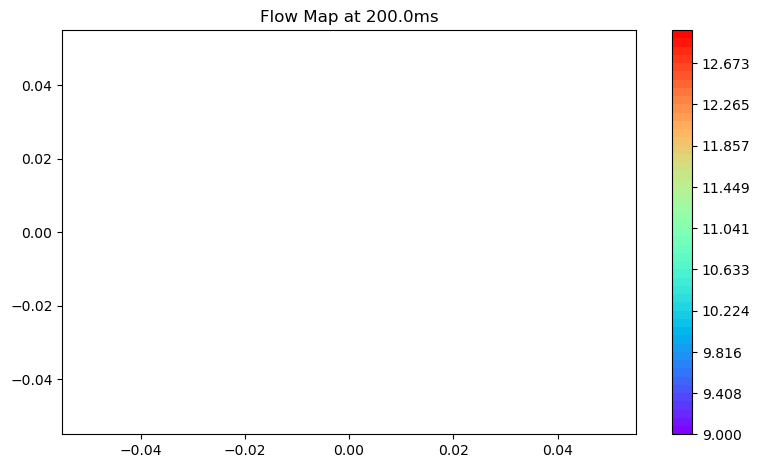

PyObject Text(0.5, 1.0, 'Flow Map at 200.0ms')

In [63]:
xflowMap(p50,1,range(9,13,length=50))
#xflowMap(n50,61,range(7,11,length=50))

In [ ]:
ftle(p50, n50, 62)

## <font color='289C4E'>Save Data<font><a id='6'></a>

#### Save Velocity, airfoil position and vorticity to an .h5 file

#### Save Particle Data to an .h5 file

#### Batch Running

In [ ]:
data =  "C:/Users/jjser/Desktop/Julia_FTLE_Karthik_Data/airfoil2D_f0.15_amp25deg_KM/data_JJ"
t = 69800
d = 200
r = 6000
n = Int(0.5*r/d)
for ii in -n:n 
    tar = t + ii * d
    name = "p" * string(t) * "_" * string(tar) * "finer.h"
    p = FTLE(500,400,9.5,12.0,9.0,11.0,tar-r,tar)
    h5open(joinpath(data,name), "w") do file
        write(file, "A", p)
    end
    name = "n" * string(t) * "_" * string(tar) * "finer.h"
    n = FTLE(500,400,9.5,12.0,9.0,11.0,tar+r,tar)
    h5open(joinpath(data,name), "w") do file
        write(file, "A", n)
    end
end
print("DONE")